In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import copy
import time

from lsh import *
from utils import *

%load_ext autoreload
%autoreload 2

# 1. Dataset

## 1.1 Random

In [2]:
n = 1000 #number of datapoints
d = 64   #data dimensionality

G = data_generator(n=n,d=d,normalize=True)
X = G.get_dataset()

In [3]:
q = G.get_query()

## 1.2 Image

In [4]:
PATH_IMGS     = "imnet-val/val/"
FILE_FEATURES = "imnet-val/cnn-50000.p"
FNAME_OFFSET  = 48 #prefix of stored file names to chop off
IMSIZE        = (224, 224)

data = dataset(FILE_FEATURES,PATH_IMGS,IMSIZE,normalize=True,fname_offt=FNAME_OFFSET)
X = data.X
d,n = X.shape

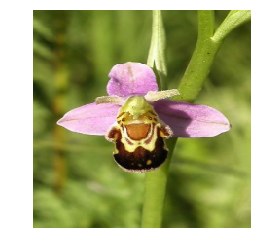

In [5]:
data.plt_img(32)

In [6]:
PATH_IMGS     = "imnet-test-1000/imgs/"
FILE_FEATURES = "imnet-test-1000/cnn-1000.p"
FNAME_OFFSET  = 23 #prefix of stored file names to chop off
IMSIZE        = (224, 224)

queries = dataset(FILE_FEATURES,PATH_IMGS,IMSIZE,normalize=True,fname_offt=FNAME_OFFSET)
Q = queries.X

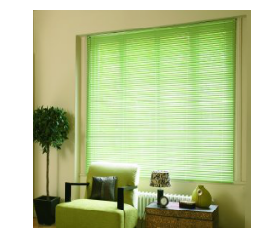

In [7]:
q_index = 166
q = copy.deepcopy(Q[:,q_index:q_index+1])
queries.plt_img(q_index)

# 2. LSH

In [8]:
b = 200 #hash bits
M = 30  #number of permutations
model = LSH(X=X,b=b,M=M)

H_data = model.H_data

# 3. Stuff to do with a single query, q

In [9]:
L = 4   #number of neighbors to make candidates
k = 10  #top-k nearest neighbors

#Compute Cosine Similarity
sims,sims_dec,sims_ranked = cos_sim_ordered(X,q)

#Compute Hamming Distance
H_q = model._get_hash(q)
hdist,hdist_inc,hdist_ranked = hamming_dist_ordered(H_data,H_q)

#Get Ranks
rank_0_opt      = sims_ranked[:k]
rank_1_hd       = hdist_ranked[:k]
rank_2_lsh_hd   = model.approx_top_k(q,k,L,refine="hamming")
rank_3_lsh_ip   = model.approx_top_k(q,k,L,refine="innerprod")
rank_4_random   = model.random_top_k(k)
rank_5_randompp = model.randompp_top_k(q,k,L)
assert((model.exact_top_k(q,k) == rank_0_opt).all())

#Compute NDCG Scores
ndcg_0_opt      = ndcg(sims,sims_dec,k,rank_0_opt)
ndcg_1_hd       = ndcg(sims,sims_dec,k,rank_1_hd)
ndcg_2_lsh_hd   = ndcg(sims,sims_dec,k,rank_2_lsh_hd)
ndcg_3_lsh_ip   = ndcg(sims,sims_dec,k,rank_3_lsh_ip)
ndcg_4_random   = ndcg(sims,sims_dec,k,rank_4_random)
ndcg_5_randompp = ndcg(sims,sims_dec,k,rank_5_randompp)

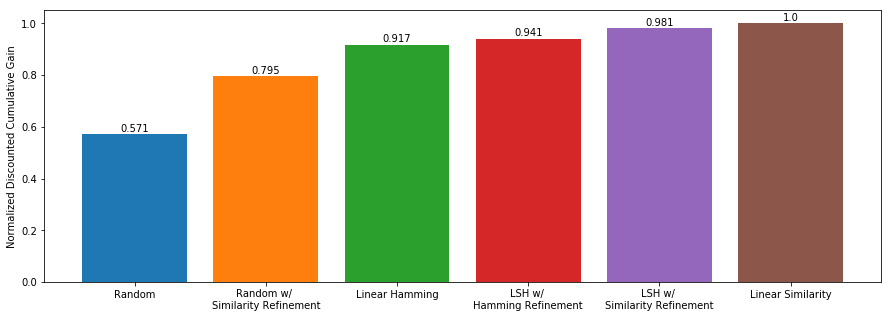

In [10]:
#Ablative Analysis
ndcg_all   = [ndcg_4_random,ndcg_5_randompp,ndcg_1_hd,ndcg_2_lsh_hd,ndcg_3_lsh_ip,ndcg_0_opt]
ndcg_names = ["Random","Random w/ \nSimilarity Refinement","Linear Hamming","LSH w/ \nHamming Refinement",
              "LSH w/ \nSimilarity Refinement","Linear Similarity"]
plt.figure(figsize=(15,5))
for i,(score,name) in enumerate(zip(ndcg_all,ndcg_names)):
    plt.bar([i],score)
    plt.text(i,score+0.01,str(round(score,3)),horizontalalignment="center")
plt.xticks(np.arange(i+1),ndcg_names)
plt.ylabel("Normalized Discounted Cumulative Gain")
plt.show()

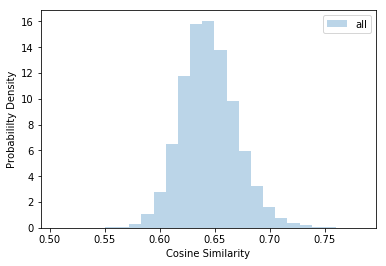

In [11]:
#Distribution of Similarity Scores
plt.hist(sims,bins=25,alpha=0.3,density=True,label="all")
plt.legend()
plt.xlabel("Cosine Similarity")
plt.ylabel("Probabililty Density")
plt.show()

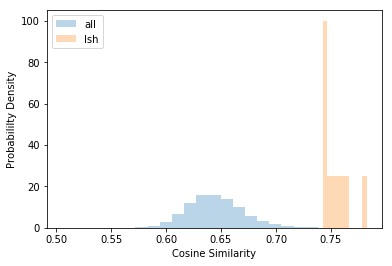

In [12]:
#Distribution of Similarity Scores with overlay of LSH results
plt.hist(sims,bins=25,alpha=0.3,density=True,label="all")
plt.hist(sims[rank_3_lsh_ip],alpha=0.3,density=True,label="lsh")
plt.legend()
plt.xlabel("Cosine Similarity")
plt.ylabel("Probabililty Density")
plt.show()

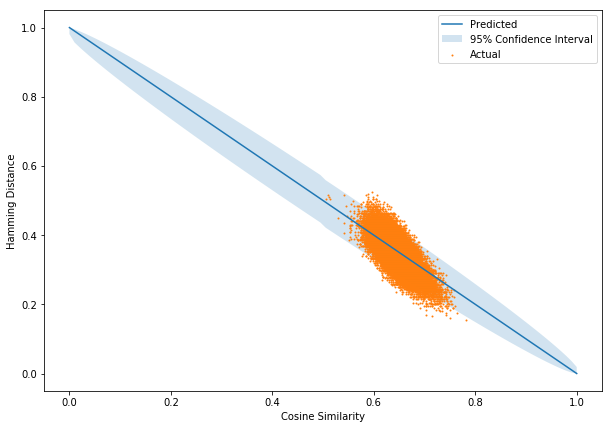

In [13]:
fig,ax = plt.subplots(1,1,figsize=(10,7))

#Predicted relashionship with confidence interval
plt.plot([0,1],[1,0],label="Predicted")
xs = np.linspace(0,1,100)
ci = binom_conf(b,xs,True)
plt.fill_between(xs,ci[0],ci[1],alpha=0.2,label="95% Confidence Interval")
del xs,ci

#Actual observed relationship
plt.scatter(sims,hdist,s=1,label="Actual")

plt.xlabel("Cosine Similarity")
plt.ylabel("Hamming Distance")
plt.legend()
plt.show()

In [14]:
%%timeit
model.approx_top_k(q,k,L,refine="hamming")

6.54 ms ± 637 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
%%timeit
model.approx_top_k(q,k,L,refine="innerprod")

9.87 ms ± 568 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
%%timeit
model.exact_top_k(q,k)

46.3 ms ± 518 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


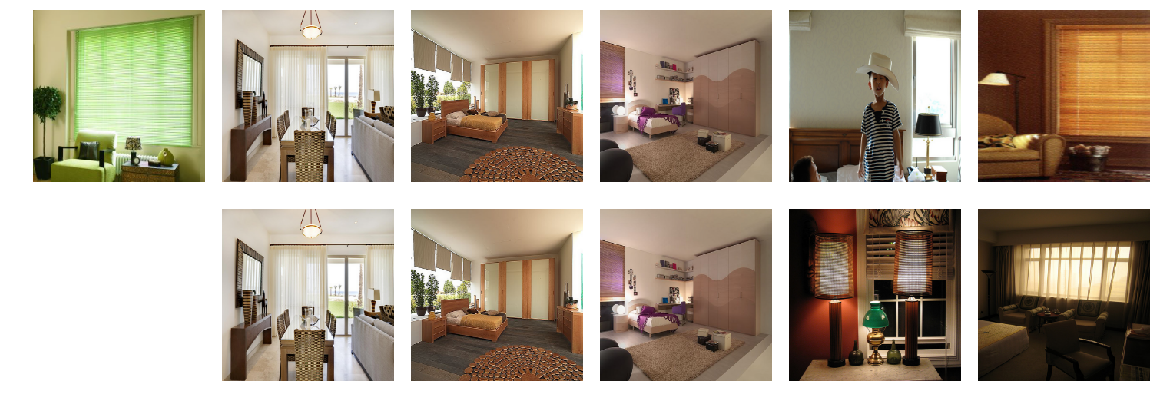

In [17]:
QUERIES_PER_PLOT = 1
PLOTS_PER_QUERY = 5

fig,ax = plt.subplots(2*QUERIES_PER_PLOT,1+PLOTS_PER_QUERY,sharex=True,sharey=True,figsize=(20,7))

for i in range(QUERIES_PER_PLOT):
    base_row = 2*i
    
    #Query
    plt.sca(ax[base_row][0])
    queries.plt_img(q_index)
    
    #Turn off axis below query
    ax[base_row+1][0].axis('off')

    for j in range(PLOTS_PER_QUERY):
        #Exact
        plt.sca(ax[base_row][1+j])
        data.plt_img(rank_0_opt[j])

        #Approximate
        plt.sca(ax[base_row+1][1+j])
        data.plt_img(rank_3_lsh_ip[j])
        
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

---